In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot

In [0]:
def makeHistoricalData(h, r, target, feature_selection):
        ''' in this code when h is 1, it means there is no history and we have just one column for each covariate
        so when h is 0, we put h equal to 1, because when h is 0 that means there no history (as when h is 1) '''
        if h == 0:
                h = 1
        
        independantOfTimeData = pd.read_csv('/content/drive/My Drive/full-fixed-data.csv')
        timeDeapandantData = pd.read_csv('/content/drive/My Drive/full-temporal-data.csv')

        allData = pd.merge(independantOfTimeData, timeDeapandantData, on='county_fips')
        allData = allData.sort_values(by=['date', 'county_fips'])
        allData = allData.reset_index(drop=True)z
        # this columns are not numercal and wouldn't be included in correlation matrix, we store them to concatenate them later
        notNumericlData = allData[['county_name', 'state_name', 'county_fips', 'state_fips', 'date']]
        allData=allData.drop(['county_name', 'state_name', 'county_fips', 'state_fips', 'date'],axis=1)
        
        # next 19 lines ranking columns with mRMR
        cor=allData.corr().abs()
        valid_feature=cor.index.drop([target])
        overall_rank_df=pd.DataFrame(index=cor.index,columns=['mrmr_rank'])
        for i in cor.index:
            overall_rank_df.loc[i,'mrmr_rank']=cor.loc[i,target]-cor.loc[i,valid_feature].mean()
        overall_rank_df=overall_rank_df.sort_values(by='mrmr_rank',ascending=False)
        overall_rank=overall_rank_df.index.tolist()
        final_rank=[]
        final_rank=overall_rank[0:2]
        overall_rank=overall_rank[2:]
        while len(overall_rank)>0:
            temp=pd.DataFrame(index=overall_rank,columns=['mrmr_rank'])
            for i in overall_rank:
                temp.loc[i,'mrmr_rank']=cor.loc[i,target]-cor.loc[i,final_rank[1:]].mean()
            temp=temp.sort_values(by='mrmr_rank',ascending=False)
            final_rank.append(temp.index[0])
            overall_rank.remove(temp.index[0])

        # next 6 lines arranges columns in order of correlations with target or by mRMR rank
        if(feature_selection=='mrmr'):
            ix=final_rank
        else:
            ix = allData.corr().abs().sort_values(target, ascending=False).index
        
        allData = allData.loc[:, ix]
        allData = pd.concat([allData, notNumericlData], axis=1)

        nameOfTimeDependantCovariates = timeDeapandantData.columns.values.tolist()
        nameOfAllCovariates = allData.columns.values.tolist()

        result = pd.DataFrame()  # we store historical data in this dataframe
        totalNumberOfCounties = len(allData['county_fips'].unique())
        totalNumberOfDays = len(allData['date'].unique())

        # in this loop we make historical data
        for name in nameOfAllCovariates:
                # if covariate is time dependant
                if name in nameOfTimeDependantCovariates and name not in ['date', 'county_fips']:
                        temporalDataFrame = allData[[name]] # selecting column of the covariate that is being processed
                        threshold = 0
                        while threshold != h:
                                # get value of covariate that is being processed in first (totalNumberOfDays-h-r+1) days
                                temp = temporalDataFrame.head((totalNumberOfDays-h-r+1)*totalNumberOfCounties).copy().reset_index(drop=True)
                                temp.rename(columns={name: (name + ' t-' + str(h-threshold-1))}, inplace=True) # renaming column
                                result = pd.concat([result, temp], axis=1)
                                # deleting the values in first day in temporalDataFrame dataframe (similiar to shift)
                                temporalDataFrame = temporalDataFrame.iloc[totalNumberOfCounties:]
                                threshold += 1
                # if covariate is independant of time
                elif name not in nameOfTimeDependantCovariates and name not in ['date', 'county_fips']:
                        temporalDataFrame = allData[[name]]
                        temp = temporalDataFrame.head((totalNumberOfDays-h-r+1)*totalNumberOfCounties).copy().reset_index(drop=True)
                        result = pd.concat([result, temp], axis=1)

        # next 3 lines is for adding FIPS code to final dataframe
        temporalDataFrame = allData[['county_fips']]
        temp = temporalDataFrame.head((totalNumberOfDays-h-r+1)*totalNumberOfCounties).copy().reset_index(drop=True)
        result.insert(0, 'county_fips', temp)

        # next 3 lines is for adding date of day (t) to final dataframe
        temporalDataFrame = allData[['date']]
        temporalDataFrame = temporalDataFrame[totalNumberOfCounties*(h-1):]
        temp = temporalDataFrame.head((totalNumberOfDays-h-r+1)*totalNumberOfCounties).copy().reset_index(drop=True)
        result.insert(1, 'date of day t', temp)

        # next 3 lines is for adding target to final dataframe
        temporalDataFrame = allData[[target]]
        temporalDataFrame = temporalDataFrame.tail((totalNumberOfDays-h-r+1)*totalNumberOfCounties).reset_index(drop=True)
        result.insert(1, 'Target', temporalDataFrame)
        for i in result.columns:
            if i.endswith('t-0'):
                result.rename(columns={i: i[:-2]}, inplace=True)

        return result

In [0]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import time
from sys import argv
from math import floor
import os




######################################################### split data to train, val, test
def splitData(numberOfCounties, main_data, target, offset, j_offset):

    X = pd.DataFrame()zzzzz
    y = pd.DataFrame()
    for i in range(numberOfCounties + 1):
        j = i * numberOfDays + j_offset
        X = X.append(main_data.loc[j:j + offset - 1])
        y = y.append(target.loc[j:j + offset - 1])

    return X, y


########################################################### clean data
def clean_data(data, numberOfSelectedCounties):

    global numberOfDays
    data = data.sort_values(by=['county_fips', 'date of day t'])
    # select the number of counties we want to use
    #numberOfSelectedCounties = numberOfCounties
    if numberOfSelectedCounties == -1:
        numberOfSelectedCounties = len(data['county_fips'].unique())

    using_data = data[(data['county_fips'] <= data['county_fips'].unique()[numberOfSelectedCounties - 1])]
    using_data = using_data.reset_index(drop=True)
    main_data = using_data.drop(['county_fips', 'state_fips', 'state_name', 'county_name', 'date of day t'],
                                axis=1)
    # target = pd.DataFrame(main_data['Target'])
    # main_data = main_data.drop(['Target'], axis=1)
    # numberOfCounties = len(using_data['county_fips'].unique())
    numberOfDays = len(using_data['date of day t'].unique())

    return main_data


########################################################### preprocess
def preprocess(main_data, validationFlag):

    target = pd.DataFrame(main_data['Target'])
    main_data = main_data.drop(['Target'], axis=1)
    # specify the size of train, validation and test sets
    test_offset = 14
    train_offset = floor(0.75 * (numberOfDays - test_offset))
    val_offset = numberOfDays - (train_offset + test_offset)
    t1 = time.time()


    if validationFlag:     # validationFlag is 1 if we want to have a validation set and 0 otherwise
        # add the functions to the multiprocessing object, loom
        X_train_train,y_train_train = splitData(numberOfSelectedCounties, main_data, target, train_offset, 0)
        X_train_train = X_train_train.reset_index(drop=True)

        X_train_val,y_train_val = np.array(splitData(numberOfSelectedCounties, main_data, target, val_offset, train_offset))
        X_train_val = X_train_val.reset_index(drop=True)

        X_test,y_test = np.array(splitData(numberOfSelectedCounties, main_data, target, test_offset, train_offset + val_offset))
        X_test = X_test.reset_index(drop=True)


        t2 = time.time()
        #print('total time of data splitting: ', t2 - t1)

        return X_train_train, X_train_val, X_test, y_train_train, y_train_val, y_test

    else:
        X_train ,y_train = splitData(numberOfSelectedCounties, main_data, target, train_offset + val_offset, 0)
        X_train = X_train.reset_index(drop=True)

        X_test ,y_test = splitData(numberOfSelectedCounties, main_data, target, test_offset, train_offset + val_offset)
        X_test = X_test.reset_index(drop=True)

        
        t2 = time.time()
        #print('total time of data splitting: ', t2 - t1)

        return X_train, X_test, y_train, y_test

In [0]:
h = 7
r = 14
target = 'confirmed'
numberOfSelectedCounties = 500  # set to -1 for all the counties

data = makeHistoricalData(h, r, target, 'mrmr')
data = clean_data(data, numberOfSelectedCounties)

################################### with validation

X_train_train, X_train_val, X_test, y_train_train, y_train_val, y_test = preprocess(data, 1) # with validation

# save to csv
train_train=pd.concat([X_train_train.reset_index(drop=True),y_train_train.reset_index(drop=True)],axis=1)
train_train.to_csv('train_train.csv',index=False)
train_val=pd.concat([X_train_val.reset_index(drop=True),y_train_val.reset_index(drop=True)],axis=1)
train_val.to_csv('train_val.csv',index=False)
test=pd.concat([X_test.reset_index(drop=True),y_test.reset_index(drop=True)],axis=1)
test.to_csv('test.csv',index=False)

In [0]:
train = pd.read_csv('/content/train_train.csv')
validation = pd.read_csv('/content/train_val.csv')
test = pd.read_csv('/content/test.csv')

In [0]:
print(train.shape, validation.shape, test.shape)

(27500, 91) (9500, 91) (7000, 91)


In [0]:
X_train = train.drop('Target', axis=1)
y_train = train['Target']

X_val = validation.drop('Target', axis=1)
y_val = validation['Target']

X_test = test.drop('Target', axis=1)
y_test = test['Target']

In [0]:
import pandas as pd
from sklearn import preprocessing

X_train = X_train.values
min_max_scaler = preprocessing.StandardScaler()
X_train = min_max_scaler.fit_transform(X_train)

X_val = X_val.values
min_max_scaler = preprocessing.StandardScaler()
X_val = min_max_scaler.fit_transform(X_val)

X_test = X_test.values
min_max_scaler = preprocessing.StandardScaler()
X_test = min_max_scaler.fit_transform(X_test)

y_train = y_train.values
min_max_scaler = preprocessing.StandardScaler()
y_train = min_max_scaler.fit_transform(y_train.reshape(-1, 1))

y_val = y_val.values
min_max_scaler = preprocessing.StandardScaler()
y_val = min_max_scaler.fit_transform(y_val.reshape(-1, 1))

y_test = y_test.values
# min_max_scaler = preprocessing.MinMaxScaler()
# y_test = min_max_scaler.fit_transform(y_test.reshape(-1, 1))

In [0]:
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(27500, 90) (7000, 90) (9500, 90)
(27500, 1) (7000,) (9500, 1)


In [0]:
X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
X_val = X_val.reshape((X_val.shape[0], 1, X_val.shape[1]))
X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))

y_train = y_train.reshape((y_train.shape[0]), )
y_val = y_val.reshape((y_val.shape[0]), )
y_test = y_test.reshape((y_test.shape[0]), )

In [0]:
print(X_train.shape, X_test.shape, X_val.shape)
print(y_train.shape, y_test.shape, y_val.shape)

(27500, 1, 90) (7000, 1, 90) (9500, 1, 90)
(27500,) (7000,) (9500,)


In [0]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Dropout
import matplotlib.pyplot as plt

# step_size = h
# num_timesteps = number of columns

model = Sequential()
model.add(LSTM(4, return_sequences=True, input_shape=(1, X_train.shape[2])))  # returns a sequence of vectors of dimension 32
model.add(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [0]:
# opt = tf.keras.optimizers.RMSprop(learning_rate=0.1)
model.compile (
    loss='mean_squared_error',
    optimizer=keras.optimizers.Adam(0.001)
)

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 1, 4)              1520      
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 256)            267264    
_________________________________________________________________
lstm_3 (LSTM)                (None, 1, 256)            525312    
_________________________________________________________________
lstm_4 (LSTM)                (None, 1, 128)            197120    
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 1,122,929
Trainable params: 1,122,929
Non-trainable params: 0
____________________________________________

In [0]:
history = model.fit (
    X_train, y_train,
    epochs=50,
    batch_size=128,
    validation_data=(X_val, y_val),
    verbose=1,
    shuffle=False
)

Train on 27500 samples, validate on 9500 samples
Epoch 1/50
27500/27500 [==============================] - 19s 701us/step - loss: 1.0130 - val_loss: 0.8888
Epoch 2/50
27500/27500 [==============================] - 16s 568us/step - loss: 0.9094 - val_loss: 0.8861
Epoch 3/50
27500/27500 [==============================] - 15s 553us/step - loss: 0.9087 - val_loss: 0.8816
Epoch 4/50
27500/27500 [==============================] - 15s 548us/step - loss: 0.8965 - val_loss: 0.8794
Epoch 5/50
27500/27500 [==============================] - 15s 555us/step - loss: 0.8992 - val_loss: 0.8954
Epoch 6/50
27500/27500 [==============================] - 15s 559us/step - loss: 0.8937 - val_loss: 0.8728
Epoch 7/50
27500/27500 [==============================] - 16s 566us/step - loss: 0.8931 - val_loss: 0.8722
Epoch 8/50
27500/27500 [==============================] - 15s 560us/step - loss: 0.8894 - val_loss: 0.8769
Epoch 9/50
27500/27500 [==============================] - 15s 556us/step - loss: 0.8898 - val_l

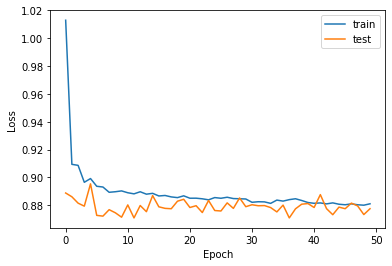

In [0]:
# plot history
import matplotlib.pyplot as plt
from google.colab import files

fig = plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
fig.savefig("h=1.png", dpi=600, quality=100)
files.download("h=1.png")

In [0]:
predictions = model.predict(X_test)
predictions = min_max_scaler.inverse_transform(predictions)

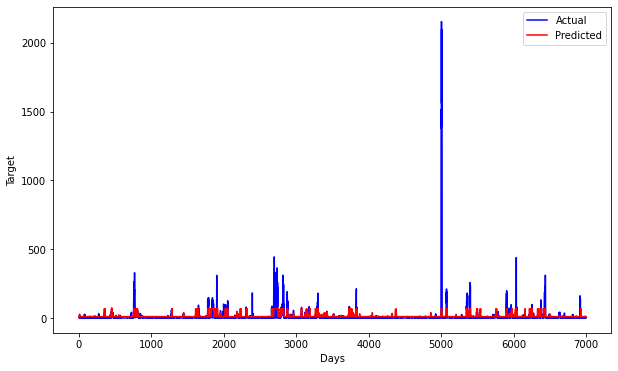

In [0]:
figure = plt.figure(figsize=(10,6))
plt.plot(y_test, color='blue', label='Actual')
plt.plot(predictions , color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('Target')
plt.legend()
plt.show()
figure.savefig('comp_h=1.png', dpi=600, quality=100)
files.download('comp_h=1.png')

In [0]:
result = pd.DataFrame()
result['Prediction'] = predictions.reshape(predictions.shape[0]).tolist()
result['Actual'] = y_test.reshape(y_test.shape[0]).tolist()
result.to_csv('result_h=1.csv', mode='w', index=False)
files.download('result_h=1.csv')